In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
BATCH_SIZE=32
IMG_SIZE=(160, 160)
SEED=123

In [5]:
train_dataset = image_dataset_from_directory("train", shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset="training", seed=SEED)

Found 59 files belonging to 3 classes.
Using 48 files for training.


In [6]:
validation_dataset = image_dataset_from_directory("train", shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset="validation", seed=SEED)

Found 59 files belonging to 3 classes.
Using 11 files for validation.


In [11]:
test_dataset = image_dataset_from_directory("test", shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 24 files belonging to 3 classes.


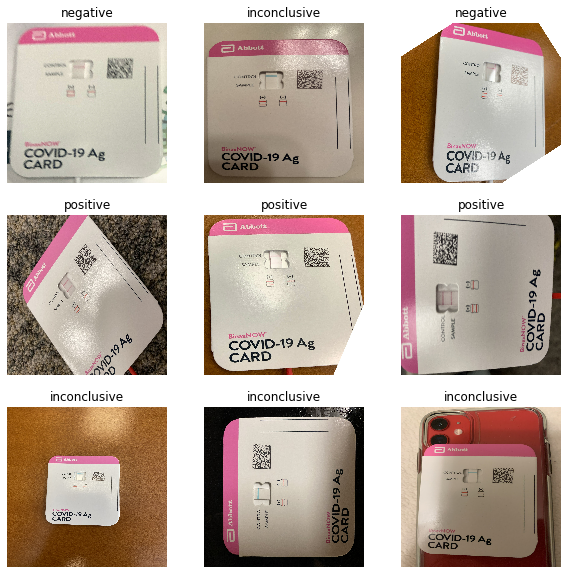

In [10]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [17]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [27]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset)

Epoch 1/100
2/2 [==============================] - 1s 630ms/step - loss: 0.8388 - accuracy: 0.2292 - val_loss: 0.6161 - val_accuracy: 0.2727
Epoch 2/100
2/2 [==============================] - 1s 603ms/step - loss: 0.6838 - accuracy: 0.3333 - val_loss: 0.5826 - val_accuracy: 0.2727
Epoch 3/100
2/2 [==============================] - 1s 613ms/step - loss: 0.6656 - accuracy: 0.2500 - val_loss: 0.5510 - val_accuracy: 0.2727
Epoch 4/100
2/2 [==============================] - 1s 598ms/step - loss: 0.7362 - accuracy: 0.2292 - val_loss: 0.5213 - val_accuracy: 0.2727
Epoch 5/100
2/2 [==============================] - 1s 590ms/step - loss: 0.7022 - accuracy: 0.2500 - val_loss: 0.4940 - val_accuracy: 0.2727
Epoch 6/100
2/2 [==============================] - 1s 584ms/step - loss: 0.7660 - accuracy: 0.2292 - val_loss: 0.4683 - val_accuracy: 0.2727
Epoch 7/100
2/2 [==============================] - 1s 598ms/step - loss: 0.6502 - accuracy: 0.3125 - val_loss: 0.4428 - val_accuracy: 0.2727
Epoch 8/100
2

2/2 [==============================] - 2s 803ms/step - loss: -0.1936 - accuracy: 0.2500 - val_loss: -0.0424 - val_accuracy: 0.4545
Epoch 59/100
2/2 [==============================] - 2s 766ms/step - loss: -0.1258 - accuracy: 0.2500 - val_loss: -0.0467 - val_accuracy: 0.4545
Epoch 60/100
2/2 [==============================] - 2s 803ms/step - loss: -0.0916 - accuracy: 0.2500 - val_loss: -0.0511 - val_accuracy: 0.4545
Epoch 61/100
2/2 [==============================] - 1s 735ms/step - loss: -0.2528 - accuracy: 0.2500 - val_loss: -0.0555 - val_accuracy: 0.4545
Epoch 62/100
2/2 [==============================] - 1s 716ms/step - loss: -0.2674 - accuracy: 0.2500 - val_loss: -0.0599 - val_accuracy: 0.4545
Epoch 63/100
2/2 [==============================] - 1s 691ms/step - loss: -0.2111 - accuracy: 0.2500 - val_loss: -0.0644 - val_accuracy: 0.4545
Epoch 64/100
2/2 [==============================] - 1s 697ms/step - loss: -0.1767 - accuracy: 0.2500 - val_loss: -0.0686 - val_accuracy: 0.4545
Epoch